In [80]:
from measurements.Pulse import Pulse
from measurements.PulseSequence import PulseSequence
from measurements.DataChannelManager import DataChannelManager

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from IPython.display import clear_output

In [3]:
from instruments.ATS9872_driver import * # alazar
from instruments.DG645_driver import * # delay generator
from instruments.M8195A_driver import * # awg
from instruments.E8257D_driver import * #RF source
from instruments.Agilent11713C_driver import * # attenuator
from instruments.SIM928_driver import * # Voltage source
from instruments.SIM970_driver import * # Voltage meter


In [4]:
awg = M8195A_driver('169.254.101.100')

In [5]:
awg.set_sampleRate(awg.get_sampleRate())
awg.getError()

In [6]:

#dg = DG645_driver('TCPIP0::169.254.101.106::inst0::INSTR') # Delay generator
alazar = ATS9872_driver()

att = Agilent11713C_driver('TCPIP0::169.254.101.101::inst0::INSTR')
RFsourceMeasurement = E8257D_driver('TCPIP0::169.254.101.103::inst0::INSTR')
RFsourceExcitation = E8257D_driver('TCPIP0::169.254.101.104::inst0::INSTR')
Voltsource = SIM928_driver('GPIB0::2::INSTR',8,step_time=0.1,step_voltage=0.001) # voltsouce step_time, step_voltage
Voltmeter = SIM970_driver('GPIB0::2::INSTR',5)

In [7]:
p1 = Pulse(length = 400e-9,
           amplitude = 1,
           frequency = 5012e6,
           phase = 0,
           envelope='gaussian')

p2 = Pulse(length = 1000e-9,
           amplitude = 1,
           frequency = 5012e6,
           phase = 90)

p3 = Pulse(length = 100e-9,
           amplitude = 1,
           frequency = 5012e6,
           phase = 0,
           envelope='gaussian')

mp = Pulse(length = 5e-6,
           amplitude = 1,
           phase = 0,
           frequency = 7400e6)

In [8]:
s1 = PulseSequence("transmon3D")

In [40]:
s1.clear()

In [41]:
s1.add(p1,'q1',2e-6)
s1.add(p2,'q1',1e-6)
s1.add(p3,'q1')
s1.add(mp,'m1')

In [42]:
s1.list_of_relative_delays

array([-9.5002e-06, -7.1002e-06, -5.1002e-06, -5.0001e-06])

In [43]:
s1.startup_delay = 1e-6

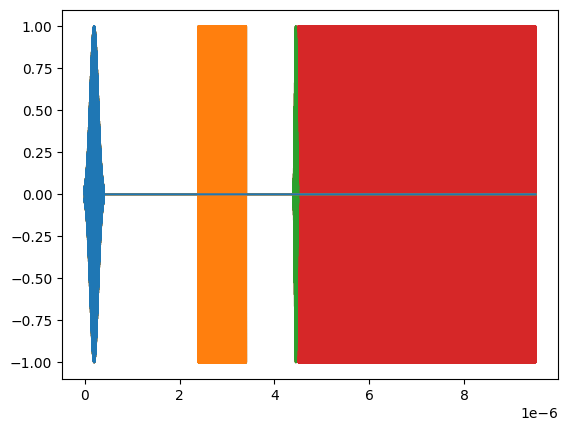

In [44]:
fig = s1.show()

In [14]:
ms = DataChannelManager('LFDQ')

In [15]:
awg.setRefInClockFrequency(10e6)
awg.setRefInClockExternal()  
awg.set_sampleRate(61440000000)
#awg.setSingleWithMarker()
awg.setDualWithMarker()
SCPI_sock_send(awg._session, ':INST:MEM:EXT:RDIV DIV2')
SCPI_sock_send(awg._session, ':TRAC2:MMOD EXT')

In [16]:
awg.getError()

In [ ]:
ms.clearAwgChannel()

ms.labelAwgChannel(2,'q1', 240e6)
ms.labelAwgChannel(1,'m1', 70e6, True)

In [19]:
channelData = ms.prepareChannelData(awg, s1, 50e-6)

In [45]:
ms.updateChannelData(channelData,s1,'q1')

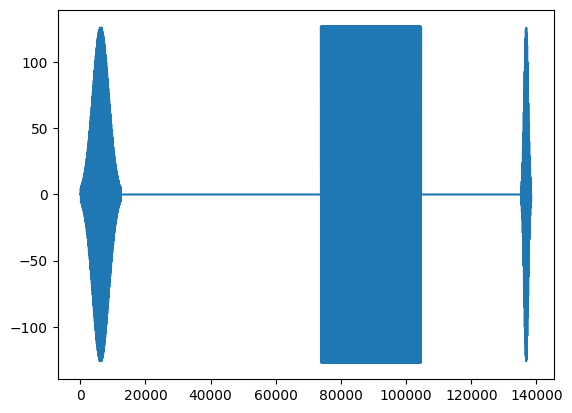

In [46]:
plt.plot(channelData['channels']['q1']['pulse_stream'])

In [23]:
awg.getError()

In [24]:
awg.stop()

In [32]:
awg.start()

In [49]:
awg.clearMemory()

In [50]:
awg.getError()

Your command:  has errors:
-300,"Device-specific error;Operation not allowed while instrument is started. Please stop first."


In [51]:
ms.allocAwgMemory(awg,channelData)

In [52]:
awg.getError()

Your command:  has errors:
-300,"Device-specific error;CH1: Segment id 1 is already defined."


In [29]:
ms.loadChannelDataToAwg(awg,channelData,'m1')
awg.getError()

In [47]:
ms.loadChannelDataToAwg(awg,channelData,'q1')
awg.getError()

In [48]:
ms.setInstrumentsMarker(awg, channelData)
awg.getError()

In [75]:
parameters = {}

parameters['RFMeasurementLength'] = 5e-6 # in seconds
parameters['RFMeasurementAmplitude'] = 18 # in dBm, this a local oscillator, it feeds two mixers.

parameters['RFExcitationLength'] = 20e-6 # in seconds
parameters['RFExcitationAmplitude'] = 11 # in dBm, this a local oscillator, it feeds one mixers.
parameters['RFExcitationDelay'] = 0.1e-9 # delay before the next pulse
parameters['RFExcitationState'] = False # if the excitation should be on while the measurement happens

parameters['fluxValue'] =  -0.015 # in volts
parameters['fluxResistance'] = 8e3 # in ohms. this is for logging only. it is resistance used for the flux source
parameters['fluxState'] = True # if the flux should be on while the measurement happens

parameters['measurementLength'] = 125e-6 # in seconds. total duration of the measurement, pulses, delays, and relaxation time

# the total number of averages is numberOfBuffers times numberOfRecordsPerBuffers
parameters['numberOfBuffers'] = 100 # number of buffer used by alazar board in the acquisition.
parameters['numberOfRecordsPerBuffers'] = 50 # number of records per buffer used by alazar board in the acquisition.

parameters['waveformHeadCut'] = 500 # number of points to be cut from head of each record in alazar. 
parameters['amplitudeReferenceAlazar'] = 9 # in dBm. the amplitude of the reference signal arriving at the alazar.
parameters['decimationValue'] =  1 # should be 1, 2, 4 or multiples of 10. it divides the alazar board clock which is 1 GHz. The clock should be at least 4 times reference frequency.

parameters['MeasurementFrequency'] = 5000e6 # in Hz, the frequency of the measurement pulse
parameters['ExcitationFrequency'] = 4500e6 # in Hz, the frequency of the excitation pulses
parameters['Measurement_IF'] = 70e6 # in Hz, the frequency of the measurement pulse
parameters['Excitation_IF'] = 240e6 # in Hz, the frequency of the measurement pulse

parameters['attenuation'] = 30 # in dB, attenuation
parameters['backgroundPlotValue'] = -60 # in dB


In [76]:
parameters

{'RFMeasurementLength': 5e-06,
 'RFMeasurementAmplitude': 18,
 'RFExcitationLength': 2e-05,
 'RFExcitationAmplitude': 11,
 'RFExcitationDelay': 1e-10,
 'RFExcitationState': False,
 'fluxValue': -0.015,
 'fluxResistance': 8000.0,
 'fluxState': True,
 'measurementLength': 0.000125,
 'numberOfBuffers': 100,
 'numberOfRecordsPerBuffers': 50,
 'waveformHeadCut': 500,
 'amplitudeReferenceAlazar': 9,
 'decimationValue': 1,
 'MeasurementFrequency': 5000000000.0,
 'ExcitationFrequency': 4500000000.0,
 'Measurement_IF': 70000000.0,
 'Excitation_IF': 240000000.0,
 'attenuation': 30,
 'backgroundPlotValue': -60}

In [35]:
RFsourceMeasurement.set_pulse_trigger_external()
RFsourceMeasurement.setPulsePolarityInverted()
RFsourceMeasurement.start_mod()

In [36]:
RFsourceExcitation.set_pulse_trigger_external()
RFsourceExcitation.setPulsePolarityNormal()
RFsourceExcitation.start_mod()

In [37]:
RFsourceMeasurement.set_amplitude(parameters['RFMeasurementAmplitude'])
RFsourceMeasurement.set_frequency(parameters['MeasurementFrequency']-parameters['Measurement_IF'])
RFsourceExcitation.set_amplitude(parameters['RFExcitationAmplitude'])
RFsourceExcitation.set_frequency(parameters['ExcitationFrequency']-parameters['Excitation_IF'])

In [89]:
awg.toggleChannelOuput(1)
awg.toggleChannelOuput(2)
awg.toggleChannelOuput(3)
awg.toggleChannelOuput(4)

Checking output state from channel 1.
AWG Response: -300,"Device-specific error;Operation not allowed while instrument is started. Please stop first."
Changing output state.
AWG Response: -300,"Device-specific error;CH1: Segment id 1 is already defined."
Checking output state from channel 2.
AWG Response: -300,"Device-specific error;Operation not allowed while instrument is started. Please stop first."
Changing output state.
AWG Response: -300,"Device-specific error;CH1: Segment id 1 is already defined."
Checking output state from channel 3.
AWG Response: -300,"Device-specific error;Operation not allowed while instrument is started. Please stop first."
Changing output state.
AWG Response: -300,"Device-specific error;CH1: Segment id 1 is already defined."
Checking output state from channel 4.
AWG Response: -300,"Device-specific error;Operation not allowed while instrument is started. Please stop first."
Changing output state.
AWG Response: -300,"Device-specific error;CH1: Segment id 1 i

In [38]:
RFsourceMeasurement.start_rf()
RFsourceExcitation.start_rf()

In [39]:
awg.start()

In [53]:
awg.stop()

In [54]:
RFsourceMeasurement.stop_rf()
RFsourceExcitation.stop_rf()

# Cavity

In [83]:
parameters['fluxValue'] = -0.1

In [86]:
Voltsource.ramp_voltage(0)

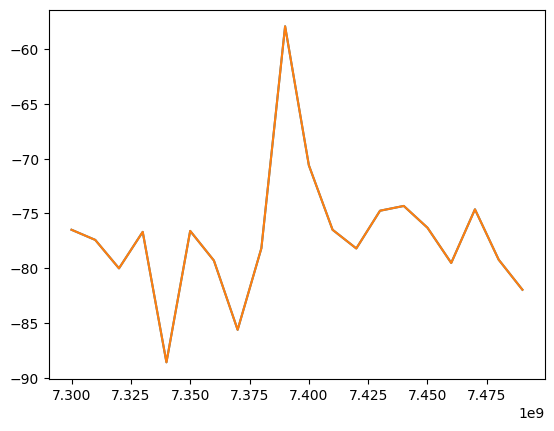

In [88]:
initial_freq = 7300e6
final_freq = 7500e6
step_Freq = 10e6

freqs = np.arange(initial_freq,final_freq,step_Freq)

#define pulses

p1 = Pulse(length = parameters['RFExcitationLength'],
           amplitude = 1,
           frequency = parameters['ExcitationFrequency'],
           phase = 0)

mp = Pulse(length = parameters['RFMeasurementLength'],
           amplitude = 1,
           phase = 0,
           frequency = parameters['Measurement_IF'])

# create pulse sequence
s1 = PulseSequence("transmon3D")
s1.startup_delay = 1e-6
parameters['RFExcitationState'] = False

s1.clear()

if parameters['RFExcitationState']: # add excitation pulse only if we want it
    s1.add(p1,'q1',parameters['RFExcitationDelay']) # add pulse p1 to channel 'q1', put a delay after pulse p1

s1.add(mp, 'm')

# prepare data to awg
ms = DataChannelManager('AWG')

awg.setRefInClockFrequency(10e6)
awg.setRefInClockExternal()  
awg.set_sampleRate(61440000000)

awg.setDualWithMarker() # use two markers, one for alazar, other for instruments
SCPI_sock_send(awg._session, ':TRAC2:MMOD EXT') # use external memory, 16 Gbytes
SCPI_sock_send(awg._session, ':INST:MEM:EXT:RDIV DIV2') # devide memory, one for each channel

# label the awg channels to what one used for the pulses
ms.clearAwgChannel()
ms.labelAwgChannel(2,'q1', parameters['Excitation_IF'])
ms.labelAwgChannel(1,'m', parameters['Measurement_IF'], True) # if set to true, that means it is a measurement channel

channelData = ms.prepareChannelData(awg, s1, parameters['measurementLength']) # add total length, pulses and relaxation to alloc the necessary bytes in memory

# clear memory, alloc new memory, put data into awg memory
awg.clearMemory()
sleep(0.05)
ms.allocAwgMemory(awg,channelData)
sleep(0.05)
ms.loadChannelDataToAwg(awg,channelData,'m')
sleep(0.05)
ms.loadChannelDataToAwg(awg,channelData,'q1')
sleep(0.05)

awg.start()

RFsourceMeasurement.set_pulse_trigger_external()
RFsourceMeasurement.setPulsePolarityInverted()
RFsourceMeasurement.start_mod()

RFsourceExcitation.set_pulse_trigger_external()
RFsourceExcitation.setPulsePolarityNormal()
RFsourceExcitation.start_mod()

RFsourceMeasurement.set_amplitude(parameters['RFMeasurementAmplitude'])

RFsourceExcitation.set_amplitude(parameters['RFExcitationAmplitude'])
RFsourceExcitation.set_frequency(parameters['ExcitationFrequency']-parameters['Excitation_IF'])

RFsourceMeasurement.start_rf()
if parameters['RFExcitationState']:
    RFsourceExcitation.start_rf()



att.set_attenuation(parameters['attenuation'])

samplingRate = 1e9/parameters['decimationValue']
pointsPerRecord = int(parameters['RFMeasurementLength']*samplingRate/256)*256

Is = np.ndarray(len(freqs))
Qs = np.ndarray(len(freqs))

Is[:] = 10**(parameters['backgroundPlotValue']/20)
Qs[:] = 10**(parameters['backgroundPlotValue']/20)


for idx,freq in enumerate(freqs):
    clear_output(wait=True)
    
    RFsourceMeasurement.set_frequency(freq-parameters['Measurement_IF'])
    sleep(0.05)

    I,Q = alazar.capture(0,
                         pointsPerRecord,
                         parameters['numberOfBuffers'],
                         parameters['numberOfRecordsPerBuffers'],
                         parameters['amplitudeReferenceAlazar'],
                         save=False,
                         waveformHeadCut=parameters['waveformHeadCut'],
                         decimation_value = parameters['decimationValue'],
                         triggerLevel_volts=0.7, 
                         triggerRange_volts=1,
                         TTL=True)

    Is[idx] = I
    Qs[idx] = Q 
    
    mags = 20*np.log10(np.sqrt(Is**2+Qs**2))

    
    plt.pause(0.05)
    plt.plot(freqs,mags)
    
clear_output(wait=True)
plt.plot(freqs,mags)

Voltsource.turn_off()
awg.stop()
RFsourceMeasurement.stop_rf()
RFsourceExcitation.stop_rf()


In [55]:
cavity.measure(parameters,freqs)

{'RFMeasurementLength': 5e-06,
 'RFMeasurementAmplitude': 18,
 'RFExcitationLength': 2e-05,
 'RFExcitationAmplitude': 11,
 'RFExcitationDelay': 1e-10,
 'RFExcitationState': False,
 'fluxValue': -0.015,
 'fluxResistance': 8000.0,
 'fluxState': False,
 'measurementLength': 0.000125,
 'numberOfBuffers': 100,
 'numberOfRecordsPerBuffers': 50,
 'waveformHeadCut': 500,
 'amplitudeReferenceAlazar': 9,
 'decimationValue': 1,
 'MeasurementFrequency': 5000000000.0,
 'ExcitationFrequency': 4500000000.0,
 'Measurement_IF': 70000000.0,
 'Excitation_IF': 240000000.0}

In [ ]:
fluxsweep.measure(parameters,freqs,volts)